In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from spline import *
from utils import read_pgm, read_eye_annotations, read_patch
from scipy.signal import convolve2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect patches

In [124]:
import os

positive_patches = os.listdir('../patches/positive/left/')

n_patches = 1000

patches = np.zeros((n_patches , 101, 101))

patch = read_patch(0, pos_neg='positive')

for i in range(n_patches):
    patch = read_patch(i)

    patches[i] = patch

# Average model (A) TEST

## Fit the model

(-3.622019631362142e-17, 1.0)

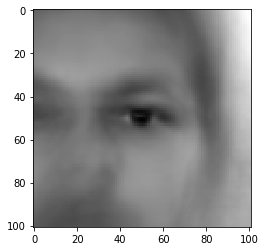

In [125]:
from models.averager import Averager
avg = Averager()
avg.train(patches)

# Display template
plt.imshow(avg.template, cmap='gray')
np.mean(avg.template), np.std(avg.template)

## Collect image and test

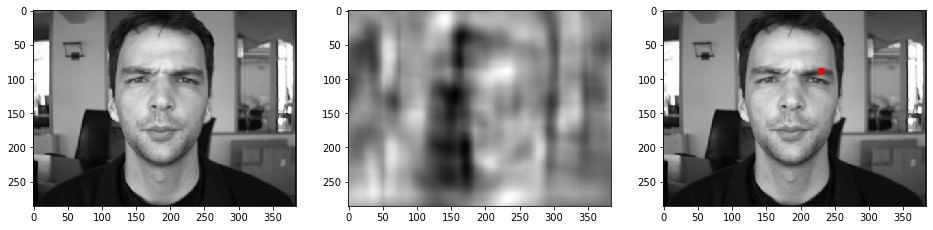

In [126]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
image = read_pgm(1)

image = (image - np.mean(image)) / np.std(image)


conv, (x, y) = avg.predict_im(image, ax3)

ax1.imshow(image, cmap='gray')
ax2.imshow(conv, cmap='gray')


In [128]:
Nx = Ny = 251  # Size of training samples
Nk = 51  # Size of the patches (x-direction)
Nl = 51  # Size of the patches (y-direction)
spline_deg = 3  # Degree of the B-spline used

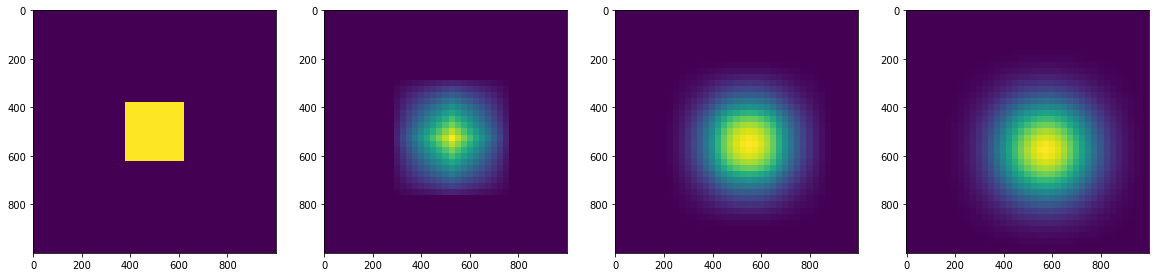

In [136]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 35))


Nx = Ny = 251
Nk = Nl = 51

sk = Nx / Nk
sl = Ny / Nk


x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

B2d = make_2D_spline_deg_n(0, sk=sk, sl=sl)
ax1.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(1, sk=sk, sl=sl)
ax2.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(2, sk=sk, sl=sl)
ax3.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(3, sk=sk, sl=sl)
ax4.imshow(B2d(x, y))


In [258]:
import numpy as np
from scipy.signal import convolve2d


class LinRegR2(object):

    def __init__(self):
        """
        """
        self.S_matrix = None
        self.template = None
        self.pupil_location = None


    def __make_s_vector(self, Nx, Ny, Nk, Nl, train_patches, spline_deg=2):
        """
        Create the S matrix

        Inputs:
        -------

        Nx (int): The size of reference image x-axis
        Ny (int): The size of reference image y-axis
        Nk (int): The number of splines x-axis
        Nl (int): The number of splines y-axis
        train_patches (array): Array of shape (num_patch, patch_size) with the training samples
        spline_deg (int): The spline degree to use 
        """

        start, stop = - train_patches[0].shape[0], train_patches[0].shape[1]

        sk = Nx / Nk
        sl = Ny / Nl

        num_patch = train_patches.shape[0]

        self.S_matrix = np.zeros((num_patch, Nk * Nl))

        Bik = make_2D_spline_deg_n(spline_deg, sk=sk, sl=sl)

        x = np.linspace(-Nx / 2, Nx / 2, Nx)
        y = np.linspace(-Ny / 2, Ny / 2, Ny)


        B = Bik(x, y)
        print(B.shape)
        plt.imshow(B)
        plt.show()

        k_1, k_2 = int((Nx - 1) / 2 - (Nk - 1) / 2), int((Nx - 1) / 2 + (Nk - 1) / 2) + 1
        l_1, l_2 = int((Ny - 1) / 2 - (Nl - 1) / 2), int((Ny - 1) / 2 + (Nl - 1) / 2) + 1

        for i in range(num_patch):

            S_matrix_i = convolve2d(B, train_patches[0],  mode='same')[k_1:k_2, l_1:l_2].flatten()
            self.S_matrix[i] = S_matrix_i


    def train(self, Nx, Ny, Nk, Nl, train_patches, labels, spline_deg=2):

        self.__make_s_vector(Nx, Ny, Nk, Nl, train_patches, spline_deg)

        c = np.linalg.inv(np.dot(self.S_matrix.H


        

(251, 251)


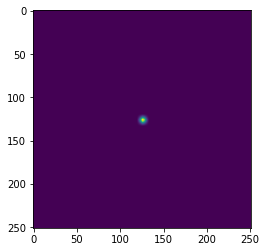

100 151 100 151


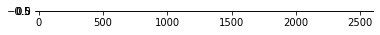

In [259]:

lin = LinRegR2()
lin.make_s_vector(Nx, Ny, Nk, Nl, np.array([patch]))

In [257]:
51*51

2601

In [78]:
image.shape

(286, 384)

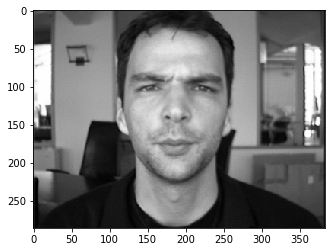

In [97]:
plt.imshow(image, cmap='gray')